 Smart Grid Optimization using Genetic Algorithm with Parallelization

In [173]:
 #import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import multiprocessing  # For parallel processing
from multiprocessing import Pool  # For using multiprocessing Pool
import time
import random
import pandas as pd
import psutil
import threading
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter


In [174]:
# Problem Parameters
NUM_NODES = 10  # Number of energy-consuming nodes (e.g., houses or districts)
NUM_SOURCES = 3  # Number of energy sources (e.g., solar, wind, hydro)
HOURS = 24  # Number of time slots (24-hour cycle)
POP_SIZE = 20  # Population size for the Genetic Algorithm
GENS = 50  # Number of generations to evolve #should be 50
MUT_RATE = 0.1  # Mutation rate (fraction of genes to mutate)
CROSS_RATE = 0.7  # Crossover rate (probability of crossover)

In [175]:
np.random.seed(42)  # Set seed for reproducibility

In [176]:
# Generate a matrix representing the electricity demand of each node for each hour
demand_matrix = np.random.randint(50, 150, size=(NUM_NODES, HOURS))

# Generate source capacities for each source and hour
source_capacity = np.random.randint(300, 500, size=(NUM_SOURCES, HOURS))

# Random cost per unit of energy for each source
cost_per_unit = np.random.uniform(1.0, 3.0, size=(NUM_SOURCES,))

# Function to create a random chromosome (an individual solution)
def create_chromosome():
    return np.random.rand(NUM_SOURCES, NUM_NODES, HOURS)

In [177]:
# Evaluate the fitness of a chromosome based on cost and penalties for constraints
def evaluate_fitness(chromosome):
    total_cost = 0  # Tracks total energy cost
    penalty = 0  # Tracks penalty for constraint violations

    # Iterate through each hour
    for h in range(HOURS):
        # Check if each node meets demand
        for n in range(NUM_NODES):
            total_power = sum(chromosome[s][n][h] for s in range(NUM_SOURCES))
            if total_power < demand_matrix[n][h]:
                penalty += (demand_matrix[n][h] - total_power) ** 2  # Penalty for under-supply

        # Check if source exceeds its capacity
        for s in range(NUM_SOURCES):
            source_total = sum(chromosome[s, :, h])
            if source_total > source_capacity[s][h]:
                penalty += (source_total - source_capacity[s][h]) ** 2  # Penalty for over-supply

            # Add cost of supplying this energy
            total_cost += sum(chromosome[s, :, h]) * cost_per_unit[s]

    # Return negative total cost and penalties as fitness (maximize fitness)
    return -np.log1p (total_cost + 10 * penalty)

In [178]:
# Initialize the population with random chromosomes
def initialize_population():
    return [create_chromosome() for _ in range(POP_SIZE)]

In [179]:
# Select top half of the population based on fitness
def selection(pop, fitnesses):
    idx = np.argsort(fitnesses)[-POP_SIZE//2:]  # Get indices of best performers
    return [pop[i] for i in idx]  # Return selected chromosomes

In [180]:
# Perform crossover between two parents to produce a child
def crossover(parent1, parent2):
    if np.random.rand() > CROSS_RATE:
        return parent1.copy()  # No crossover, return parent
    point = np.random.randint(1, HOURS)  # Random crossover point along time axis
    child = parent1.copy()
    child[:, :, point:] = parent2[:, :, point:]  # Swap the latter part from parent2
    return child

In [181]:
# Mutate the chromosome by slightly changing a few values
def mutate(chromosome):
    for _ in range(int(MUT_RATE * NUM_NODES * HOURS)):
        s = np.random.randint(NUM_SOURCES)  # Random source
        n = np.random.randint(NUM_NODES)  # Random node
        h = np.random.randint(HOURS)  # Random hour
        # Apply small Gaussian noise and clip to valid range [0, 1]
        chromosome[s][n][h] = np.clip(chromosome[s][n][h] + np.random.normal(0, 0.1), 0, 1)
    return chromosome

In [182]:
# Evaluate the population using either parallel or serial processing
def evaluate_population(pop, parallel=True):
    if parallel:
        with Pool(processes=multiprocessing.cpu_count()) as pool:
            return pool.map(evaluate_fitness, pop)  # Parallel fitness computation
    else:
        return list(map(evaluate_fitness, pop))  # Serial fitness computation

In [183]:
# Run the entire genetic algorithm process
def run_ga(parallel):
    pop = initialize_population()  # Create initial population
    best_fitnesses = []  # Store best fitness over generations
    start = time.time()  # Start timer

    # Evolve for defined number of generations
    for gen in range(GENS):
        fitnesses = evaluate_population(pop, parallel=parallel)  # Get fitness of all individuals
        best_fitnesses.append(max(fitnesses))  # Store best fitness
        selected = selection(pop, fitnesses)  # Select best individuals

        # Generate new population from selected
        new_pop = []
        while len(new_pop) < POP_SIZE:
            p1, p2 = random.sample(selected, 2)  # Randomly select two parents
            child = crossover(p1, p2)  # Create child by crossover
            new_pop.append(mutate(child))  # Mutate and add to population

        pop = new_pop  # Update population

    duration = time.time() - start  # Total execution time
    return best_fitnesses, duration

In [184]:
# Run GA in parallel mode
parallel_result, parallel_time = run_ga(parallel=True)

# Run GA in serial mode
serial_result, serial_time = run_ga(parallel=False)

In [185]:
# Export plots and logs
def export_results(parallel_result, serial_result, df_log, all_fitnesses):
  # Plot convergence curves
  plt.plot(parallel_result, label='Parallel GA')
  plt.plot(serial_result, label='Serial GA')
  plt.title('GA Convergence')
  plt.xlabel('Generation')
  plt.ylabel('Best Fitness')
  plt.legend()
  plt.grid(True)
  plt.show()

In [186]:
# Print execution times for comparison
print(f"Parallel Execution Time: {parallel_time:.2f}s")
print(f"Serial Execution Time:   {serial_time:.2f}s")

Parallel Execution Time: 4.87s
Serial Execution Time:   2.49s


In [187]:
def run_ga_with_log(parallel=True):

    #Runs the Genetic Algorithm and logs the best individual of each generation.
    #Returns:
    #    - A DataFrame containing generation-wise summary of the best individual.
    #    - Total execution time.


    pop = initialize_population()  # Create the initial population of chromosomes (random solutions)
    log = []  # This list will store the best individual's info per generation
    start = time.time()  # Start measuring execution time

    # Repeat for the total number of generations
    for gen in range(GENS):
        # Evaluate the fitness of each individual in the population
        fitnesses = evaluate_population(pop, parallel=parallel)

        # Identify the best individual based on maximum fitness
        best_idx = np.argmax(fitnesses)             # Get index of the best fitness
        best_fitness = fitnesses[best_idx]          # Get the actual fitness score
        best_individual = pop[best_idx]             # Get the chromosome (solution) itself

        # Summarize the best individual's characteristics for logging
        summary = {
            'Generation': gen + 1,                           # Current generation (starting from 1)
            'a': np.mean(best_individual[0]),                # Mean allocation from source 0 (labelled 'a')
            'b': np.mean(best_individual[1]),                # Mean allocation from source 1 (labelled 'b')
            'c': np.mean(best_individual[2]),                # Mean allocation from source 2 (labelled 'c')
            'Fitness': best_fitness                          # Best fitness score in this generation
        }
        log.append(summary)  # Save the summary to the log list

        # --- Generate next generation ---

        selected = selection(pop, fitnesses)  # Select the top-performing individuals (elitism/selection)

        new_pop = []  # Initialize new population
        while len(new_pop) < POP_SIZE:
            # Randomly choose two parents from the selected individuals
            p1, p2 = random.sample(selected, 2)
            child = crossover(p1, p2)          # Generate offspring via crossover
            child = mutate(child)              # Apply mutation to introduce diversity
            new_pop.append(child)              # Add new child to next generation

        pop = new_pop  # Replace current population with the new one

    duration = time.time() - start  # Calculate total execution time

    # Convert log into a Pandas DataFrame and return with execution time
    return pd.DataFrame(log), duration

In [188]:
# Run GA and log best individuals
df_log, exec_time = run_ga_with_log(parallel=True)

# Display as a clean table

print(tabulate(df_log, headers='keys', tablefmt='github', showindex=False))


|   Generation |        a |        b |        c |   Fitness |
|--------------|----------|----------|----------|-----------|
|            1 | 0.516762 | 0.512911 | 0.514012 |  -17.031  |
|            2 | 0.518349 | 0.512532 | 0.516296 |  -17.0309 |
|            3 | 0.520672 | 0.536074 | 0.520331 |  -17.0306 |
|            4 | 0.516306 | 0.530046 | 0.532875 |  -17.0305 |
|            5 | 0.512413 | 0.500466 | 0.557886 |  -17.0303 |
|            6 | 0.512605 | 0.500891 | 0.558389 |  -17.0303 |
|            7 | 0.551848 | 0.516165 | 0.534236 |  -17.03   |
|            8 | 0.550408 | 0.521163 | 0.535769 |  -17.0298 |
|            9 | 0.525318 | 0.523014 | 0.559044 |  -17.0299 |
|           10 | 0.533462 | 0.525677 | 0.545475 |  -17.03   |
|           11 | 0.534715 | 0.519957 | 0.567682 |  -17.0298 |
|           12 | 0.533195 | 0.49874  | 0.571427 |  -17.0296 |
|           13 | 0.54828  | 0.540263 | 0.536777 |  -17.0293 |
|           14 | 0.548929 | 0.518764 | 0.572255 |  -17.0292 |
|       

In [189]:
def run_ga_with_log_and_tracking(parallel=True):


    pop = initialize_population()  # Generate the initial population (random energy allocations)
    log = []  # Stores summary of the best individual for each generation
    all_fitnesses = []  # Stores complete fitness array per generation (used for plotting)
    start = time.time()  # Start execution timer

   # Repeat for each generation
    for gen in range(GENS):
        # Evaluate the fitness of the current population (either in parallel or serial)
        fitnesses = evaluate_population(pop, parallel=parallel)

        # Save all fitness scores for this generation (used for plotting range later)
        all_fitnesses.append(fitnesses)

        # Identify the best individual based on fitness
        best_idx = np.argmax(fitnesses)        # Index of the best fitness value
        best_fitness = fitnesses[best_idx]     # Best fitness score
        best_individual = pop[best_idx]        # Best chromosome (energy allocation)

        # Create a summary dictionary of best solution characteristics
        summary = {
            'Generation': gen + 1,                         # Current generation number (1-based)
            'a': np.mean(best_individual[0]),              # Average allocation from source 0
            'b': np.mean(best_individual[1]),              # Average allocation from source 1
            'c': np.mean(best_individual[2]),              # Average allocation from source 2
            'Fitness': best_fitness                        # Best fitness score
        }
        log.append(summary)  # Add the summary to the log list

        # Create the next generation
        selected = selection(pop, fitnesses)  # Select top individuals (selection strategy)

        new_pop = []  # Initialize new population list
        while len(new_pop) < POP_SIZE:
            p1, p2 = random.sample(selected, 2)  # Select two parents at random from selected pool
            child = crossover(p1, p2)            # Perform crossover to generate offspring
            child = mutate(child)                # Apply mutation to introduce variation
            new_pop.append(child)                # Add the new child to the new population

        pop = new_pop  # Replace the old population with the new one

    # Record total execution time
    duration = time.time() - start

    # Return summary DataFrame, all fitness history, and execution time
    return pd.DataFrame(log), all_fitnesses, duration

In [190]:
def plot_fitness_range(all_fitnesses):
    best_fitness = [max(f) for f in all_fitnesses]
    min_fitness = [min(f) for f in all_fitnesses]
    max_fitness = [max(f) for f in all_fitnesses]

    generations = list(range(1, len(all_fitnesses) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(generations, best_fitness, label='Best Fitness', color='black')
    plt.fill_between(generations, min_fitness, max_fitness, color='gray', alpha=0.4, label='Fitness Range')

    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness Over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

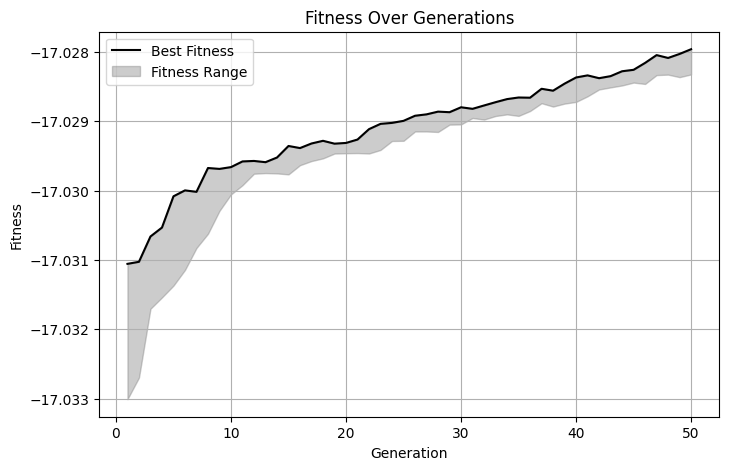

In [191]:
# Run GA
df_log, all_fitnesses, exec_time = run_ga_with_log_and_tracking(parallel=True)

# Plot fitness range
plot_fitness_range(all_fitnesses)

Greedy Algorithm

In [192]:
def greedy_energy_allocation(demand_matrix, source_capacity, cost_per_unit):

    start = time.perf_counter() # start measuring executing time
    memory = psutil.virtual_memory()

    # Initialize an empty allocation matrix to store energy assignments
    allocation = np.zeros((NUM_SOURCES, NUM_NODES, HOURS))

    # Sort sources by increasing cost per unit, so cheaper sources are used first
    sorted_sources = np.argsort(cost_per_unit)

    # Loop over each hour in the 24-hour cycle
    for h in range(HOURS):
        # Loop over each node (energy consumer)
        for n in range(NUM_NODES):
            remaining_demand = demand_matrix[n][h]  # Retrieve the energy demand of node 'n' at hour 'h'

            # Loop through sources in order of increasing cost
            for s in sorted_sources:
                # Calculate how much energy has already been used from this source at hour 'h'
                used_capacity = allocation[s, :, h].sum()

                # Determine the remaining capacity of this source at hour 'h'
                available = source_capacity[s][h] - used_capacity

                # Allocate the minimum between available energy and remaining demand
                assigned = min(available, remaining_demand)

                # Assign the energy to the node from this source at this hour
                allocation[s][n][h] = assigned

                # Reduce the remaining demand for the node
                remaining_demand -= assigned

                # If the demand is fully satisfied, move to the next node
                if remaining_demand <= 0:
                    break
    duration = time.perf_counter() - start  # Total execution time
    # Return the completed energy allocation matrix
    return allocation, duration

In [193]:
# Generate greedy allocation
greedy_alloc, greedy_time = greedy_energy_allocation(demand_matrix, source_capacity, cost_per_unit)

# Evaluate greedy performance using the same fitness function
greedy_fitness = evaluate_fitness(greedy_alloc)

# Compare to best GA result
ga_log, _, _ = run_ga_with_log_and_tracking()
ga_best_fitness = ga_log['Fitness'].max()

print(f"Greedy Fitness: {greedy_fitness:.2f}")
print(f"Best GA Fitness: {ga_best_fitness:.2f}")
print(f"Greedy Algorithm Runtime: {greedy_time} seconds")

Greedy Fitness: -11.02
Best GA Fitness: -17.03
Greedy Algorithm Runtime: 0.0026708800000960764 seconds


CPU Usage Monitoring

In [194]:
# Monitor CPU Class
class CPUMonitor(threading.Thread):
    def __init__(self, interval=0.5):
        super().__init__()
        self.interval = interval
        self.usage = []
        self.running = True

    def run(self):
        while self.running:
            cpu = psutil.cpu_percent(interval=None)
            self.usage.append(cpu)
            time.sleep(self.interval)

    def stop(self):
        self.running = False

In [195]:
# Start CPU Monitor
monitor = CPUMonitor(interval=0.1)  # Faster sampling (every 0.1 sec)
monitor.start()

# Run your Genetic Algorithm here (serial or parallel)
serial_history = run_ga(parallel = False)

# Stop CPU Monitor
monitor.stop()
monitor.join()

In [196]:
cpu_percent = psutil.cpu_percent(interval=1)
memory = psutil.virtual_memory()
memory_used_mb = (memory.total - memory.available) / 1024**2

print("Resource Usage:")
print(f"CPU Usage: {cpu_percent:.1f}%")
print(f"Memory Usage: {memory_used_mb:.2f} MB")

Resource Usage:
CPU Usage: 3.0%
Memory Usage: 1299.46 MB


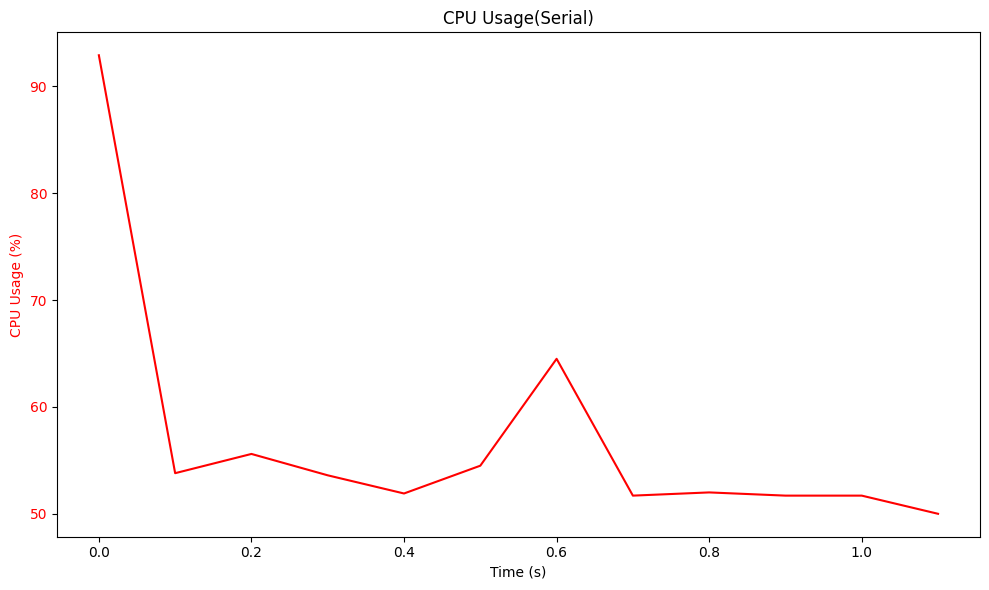

In [197]:
# Create time axis for CPU usage
cpu_time = [i * monitor.interval for i in range(len(monitor.usage))]

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot CPU usage
ax1.plot(cpu_time, monitor.usage, 'r-', label="CPU Usage (%)")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('CPU Usage (%)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Titles and grid
plt.title("CPU Usage(Serial)")
fig.tight_layout()
plt.show()

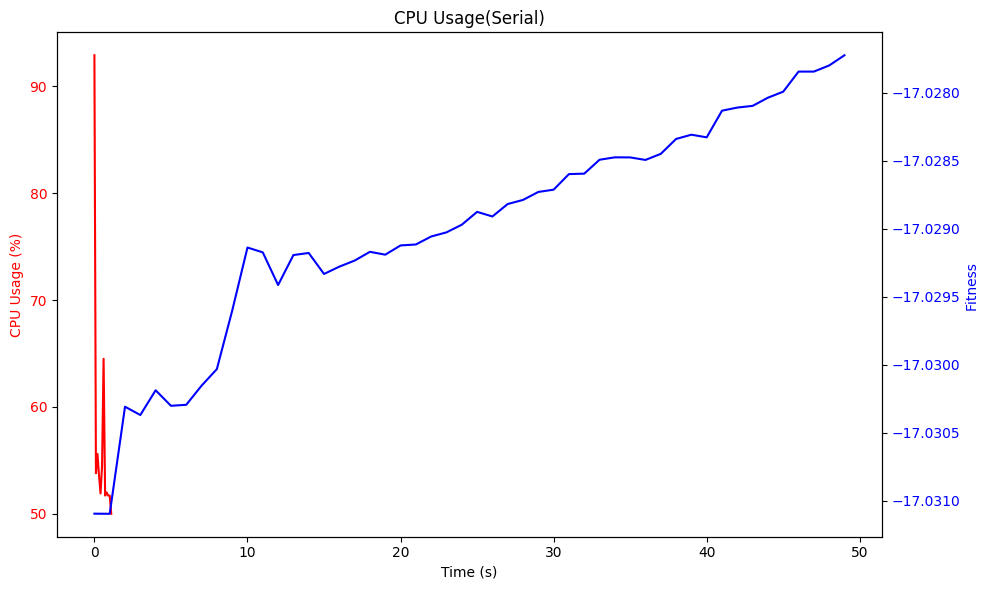

In [198]:
# Create time axis for CPU usage
cpu_time = [i * monitor.interval for i in range(len(monitor.usage))]

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot CPU usage
ax1.plot(cpu_time, monitor.usage, 'r-', label="CPU Usage (%)")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('CPU Usage (%)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create second y-axis for fitness
ax2 = ax1.twinx()
# Extract the fitness history from the serial_history tuple
ax2.plot(range(len(serial_history[0])), serial_history[0], 'b-', label="Fitness (GA Convergence)")
ax2.set_ylabel('Fitness ', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Titles and grid
plt.title("CPU Usage(Serial)")
fig.tight_layout()
plt.show()

In [199]:
print(type(serial_history))
print(len(serial_history))
print(type(serial_history[0]))


<class 'tuple'>
2
<class 'list'>


In [225]:
#For Parallel
# Start CPU Monitor
monitor = CPUMonitor(interval=0.5)
monitor.start()

# Run the Genetic Algorithm here
parallel_history = run_ga(parallel=True)

# Stop CPU Monitor
monitor.stop()
monitor.join()

In [226]:
cpu_percent = psutil.cpu_percent(interval=1)
memory = psutil.virtual_memory()
memory_used_mb = (memory.total - memory.available) / 1024**2

print("Resource Usage:")
print(f"CPU Usage: {cpu_percent:.1f}%")
print(f"Memory Usage: {memory_used_mb:.2f} MB")

Resource Usage:
CPU Usage: 3.5%
Memory Usage: 1387.43 MB


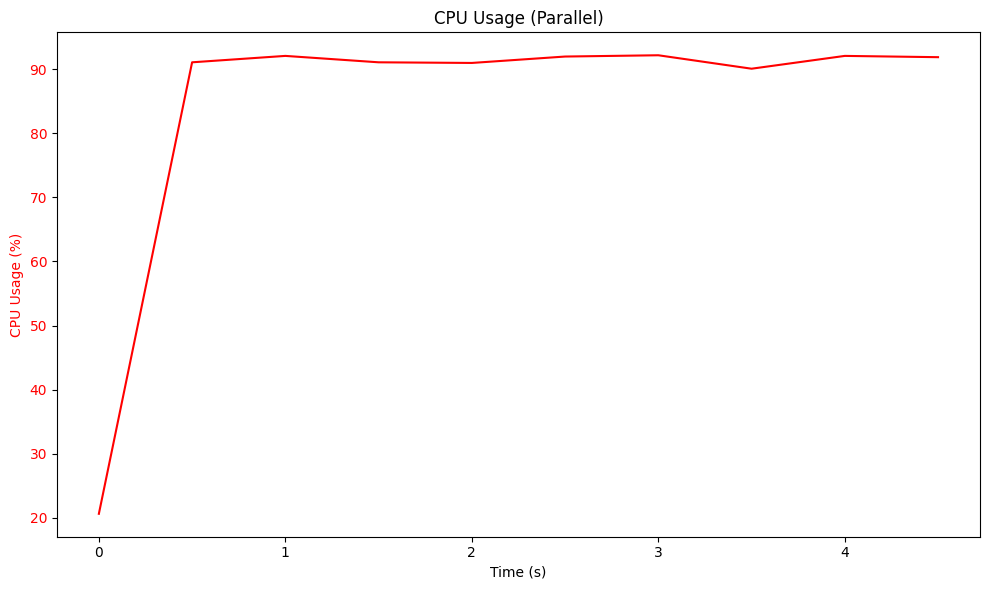

In [231]:
# Create time axis for CPU usage
cpu_time = [i * monitor.interval for i in range(len(monitor.usage))]

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot CPU usage
ax1.plot(cpu_time, monitor.usage, 'r-', label="CPU Usage (%)")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('CPU Usage (%)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Titles and grid
plt.title("CPU Usage (Parallel)")
fig.tight_layout()
plt.show()

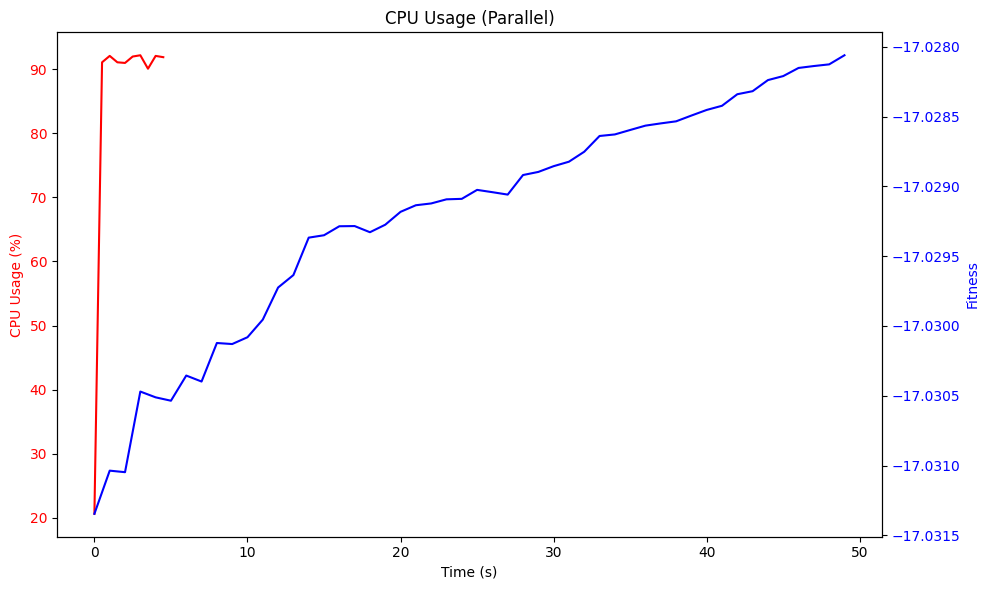

In [230]:
# Create time axis for CPU usage
cpu_time = [i * monitor.interval for i in range(len(monitor.usage))]

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot CPU usage
ax1.plot(cpu_time, monitor.usage, 'r-', label="CPU Usage (%)")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('CPU Usage (%)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create second y-axis for fitness
ax2 = ax1.twinx()
# Extract the fitness history from the parallel_history tuple
ax2.plot(range(len(parallel_history[0])), parallel_history[0], 'b-', label="Fitness (GA Convergence)")
ax2.set_ylabel('Fitness', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Titles and grid
plt.title("CPU Usage (Parallel)")
fig.tight_layout()
plt.show()

For greedy

In [212]:
# Record CPU times before running greedy
cpu_start = psutil.cpu_times_percent(interval=None)
start_time = time.perf_counter()

# Run greedy algorithm
result = greedy_energy_allocation(demand_matrix, source_capacity, cost_per_unit)

end_time = time.perf_counter()
cpu_end = psutil.cpu_times_percent(interval=None)

# Calculate actual runtime
greedy_time = end_time - start_time

print(f"Greedy Runtime: {greedy_time:.6f} seconds")

# CPU usage estimate based on user/system time
cpu_usage_est = 100 - cpu_end.idle
print(f"Estimated CPU Usage During Greedy: {cpu_usage_est:.2f}%")
# Stop CPU Monitor
monitor.stop()
monitor.join()

Greedy Runtime: 0.003849 seconds
Estimated CPU Usage During Greedy: 99.00%


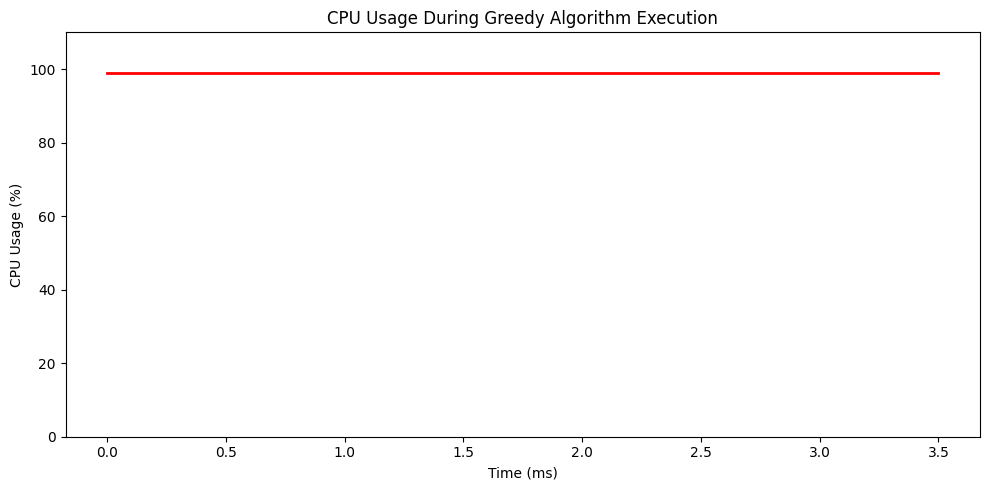

In [236]:
# Simulated time in milliseconds
time_ms = np.linspace(0, 3.5, 10)  # Simulates 10 time points over 3.5 ms
cpu_usage = np.full_like(time_ms, cpu_usage_est)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time_ms, cpu_usage, color='red', linewidth=2)
plt.title("CPU Usage During Greedy Algorithm Execution")
plt.xlabel("Time (ms)")
plt.ylabel("CPU Usage (%)")
plt.ylim(0, 110)
plt.tight_layout()
plt.show()

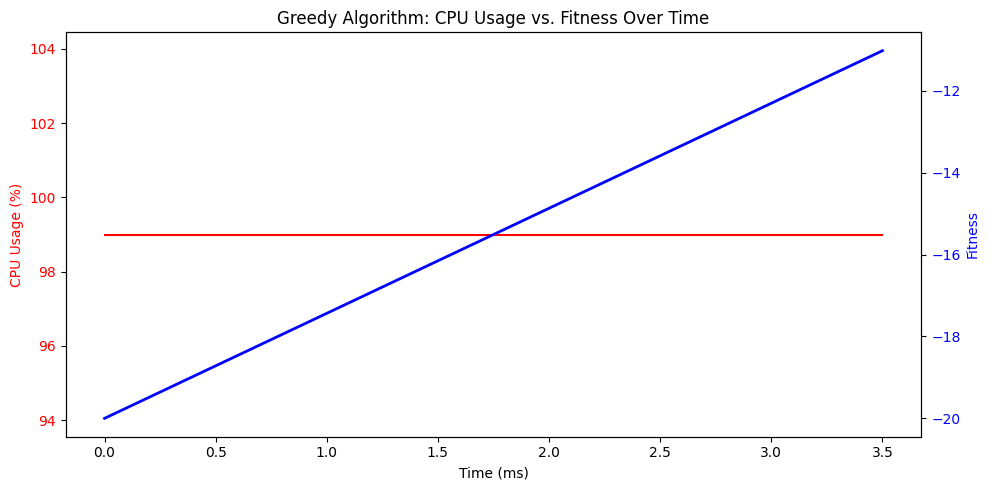

In [238]:
time_ms = np.linspace(0, 3.5, 10)
cpu_usage = np.full_like(time_ms, cpu_usage_est)

# Simulated fitness improvement toward best greedy result (-11.02)
fitness = np.linspace(-20, -11.02, len(time_ms))

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot CPU usage on left y-axis
ax1.plot(time_ms, cpu_usage, 'r', label='CPU Usage (%)')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('CPU Usage (%)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Plot fitness on right y-axis
ax2 = ax1.twinx()
ax2.plot(time_ms, fitness, 'b-', label='Fitness (Greedy)', linewidth=2)
ax2.set_ylabel('Fitness', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Titles and layout
plt.title("Greedy Algorithm: CPU Usage vs. Fitness Over Time")
fig.tight_layout()
plt.show()

In [239]:
# Runtime Comparison

print("Runtime Comparison (in seconds):")
print(f"Parallel GA Runtime: {parallel_time:.2f}")
print(f"Serial GA Runtime:   {serial_time:.2f}")
print(f"Greedy Algorithm Runtime:   {greedy_time:.6f}")


Runtime Comparison (in seconds):
Parallel GA Runtime: 4.87
Serial GA Runtime:   2.49
Greedy Algorithm Runtime:   0.003849


Analyze trade-offs between convergence speed and solution quality under different
parameter settings (e.g., population size, mutation rate).

In [207]:
# Define various parameter variations
parameter_variations = [
    {"POP_SIZE": 20, "GENS": 50, "MUT_RATE": 0.1, "CROSS_RATE": 0.7},  # Current
    {"POP_SIZE": 50, "GENS": 50, "MUT_RATE": 0.1, "CROSS_RATE": 0.7},  # Larger population
    {"POP_SIZE": 20, "GENS": 100, "MUT_RATE": 0.1, "CROSS_RATE": 0.7}, # More generations
    {"POP_SIZE": 20, "GENS": 50, "MUT_RATE": 0.2, "CROSS_RATE": 0.7},  # Higher mutation rate
    {"POP_SIZE": 20, "GENS": 50, "MUT_RATE": 0.1, "CROSS_RATE": 0.9}   # Higher crossover rate
]

In [169]:
# Initialize lists to store results
all_results = []
all_exec_times = []

# Iterate through parameter variations
for params in parameter_variations:
    # Dynamically update global variables
    globals()['POP_SIZE'] = params['POP_SIZE']
    globals()['GENS'] = params['GENS']
    globals()['MUT_RATE'] = params['MUT_RATE']
    globals()['CROSS_RATE'] = params['CROSS_RATE']

    # Run the GA with updated parameters
    df_log, all_fitnesses, exec_time = run_ga_with_log_and_tracking(parallel=True)

    # Store the results
    all_results.append({'params': params, 'df_log': df_log, 'all_fitnesses': all_fitnesses})
    all_exec_times.append({'params': params, 'exec_time': exec_time})


Collect and store results from the genetic algorithm runs for each parameter variation.

In [170]:
print("Execution times for each parameter combination:")
for item in all_exec_times:
    print(f"Parameters: {item['params']}, Execution Time: {item['exec_time']:.2f}s")

# Create a DataFrame to display results
exec_time_df = pd.DataFrame(all_exec_times)
exec_time_df['params_str'] = exec_time_df['params'].apply(lambda x: ', '.join([f"{k}:{v}" for k, v in x.items()]))

exec_time_df[['params_str', 'exec_time']].head()


Execution times for each parameter combination:
Parameters: {'POP_SIZE': 20, 'GENS': 50, 'MUT_RATE': 0.1, 'CROSS_RATE': 0.7}, Execution Time: 5.68s
Parameters: {'POP_SIZE': 50, 'GENS': 50, 'MUT_RATE': 0.1, 'CROSS_RATE': 0.7}, Execution Time: 6.93s
Parameters: {'POP_SIZE': 20, 'GENS': 100, 'MUT_RATE': 0.1, 'CROSS_RATE': 0.7}, Execution Time: 12.18s
Parameters: {'POP_SIZE': 20, 'GENS': 50, 'MUT_RATE': 0.2, 'CROSS_RATE': 0.7}, Execution Time: 6.13s
Parameters: {'POP_SIZE': 20, 'GENS': 50, 'MUT_RATE': 0.1, 'CROSS_RATE': 0.9}, Execution Time: 4.47s


,params_str,exec_time
0,"POP_SIZE:20, GENS:50, MUT_RATE:0.1, CROSS_RATE...",5.684106
1,"POP_SIZE:50, GENS:50, MUT_RATE:0.1, CROSS_RATE...",6.931285
2,"POP_SIZE:20, GENS:100, MUT_RATE:0.1, CROSS_RAT...",12.182629
3,"POP_SIZE:20, GENS:50, MUT_RATE:0.2, CROSS_RATE...",6.128141
4,"POP_SIZE:20, GENS:50, MUT_RATE:0.1, CROSS_RATE...",4.472239


Analyze solution quality


In [171]:
# Extract the final best fitness for each parameter combination
final_fitness_data = []
for result in all_results:
    params = result['params']
    df_log = result['df_log']
    final_best_fitness = df_log['Fitness'].iloc[-1]
    params_str = ', '.join([f"{k}:{v}" for k, v in params.items()])
    final_fitness_data.append({'params_str': params_str, 'Final_Best_Fitness': final_best_fitness})

# Create a pandas DataFrame
final_fitness_df = pd.DataFrame(final_fitness_data)

# Display the DataFrame
print("Final Best Fitness for each parameter combination:")
display(final_fitness_df)


Final Best Fitness for each parameter combination:


,params_str,Final_Best_Fitness
0,"POP_SIZE:20, GENS:50, MUT_RATE:0.1, CROSS_RATE...",-17.027953
1,"POP_SIZE:50, GENS:50, MUT_RATE:0.1, CROSS_RATE...",-17.026491
2,"POP_SIZE:20, GENS:100, MUT_RATE:0.1, CROSS_RAT...",-17.025860
3,"POP_SIZE:20, GENS:50, MUT_RATE:0.2, CROSS_RATE...",-17.027198
4,"POP_SIZE:20, GENS:50, MUT_RATE:0.1, CROSS_RATE...",-17.027935


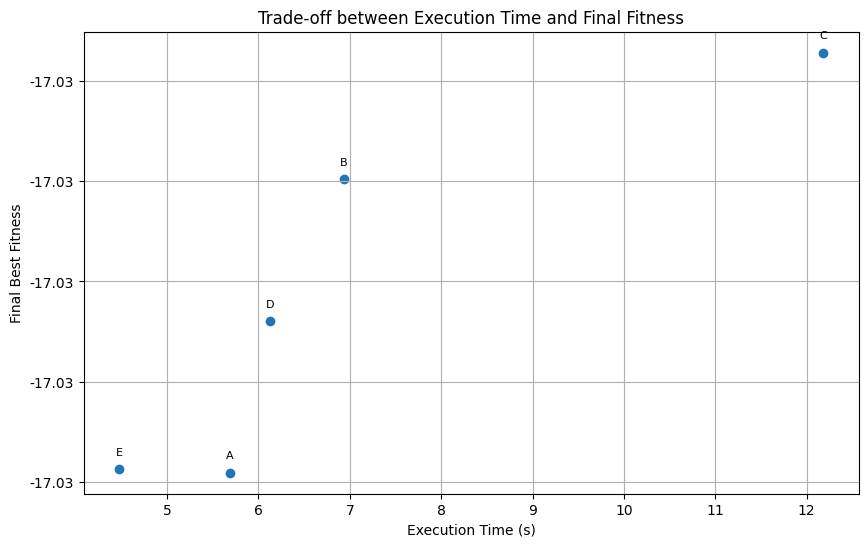

In [240]:
# visualize trade offs
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(10, 6))
plt.scatter(exec_time_df['exec_time'], final_fitness_df['Final_Best_Fitness'])

# Annotate points with letters
labels = ['A', 'B', 'C', 'D', 'E']
for i, txt in enumerate(labels):
    plt.annotate(txt, (exec_time_df['exec_time'][i], final_fitness_df['Final_Best_Fitness'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)


plt.xlabel('Execution Time (s)')
plt.ylabel('Final Best Fitness')
plt.title('Trade-off between Execution Time and Final Fitness')
plt.grid(True)

# Set y-axis tick formatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()